FIRST FILE : Manage, import and format data

In [45]:
from enum import Enum
from PIL import ImageOps, Image
from tqdm import tqdm
import numpy as np
import glob

Define all datasets paths we might use in the AI training

In [46]:
class Dataset(Enum):
    TRAIN = "../datasets/chest_Xray/train/"
    TEST = "../datasets/chest_Xray/test/"
    VAL = "../datasets/chest_Xray/val/"

Define possible value for each entry we'll have

In [47]:
class Values(Enum):
    NORMAL = 0
    PNEUMONIA = 1

Import pictures from a chosen dataset, pass it into greyscale if necessary, resize images to a fixed length and transform it to array.
This function also fill a 2nd array containing for each image it's value ("pneumonia" or "normal")

In [48]:
def import_dataset(dataset_type, size):
    print("Loading dataset " + dataset_type.value)
    images = []
    #Get every filepaths for all images
    for rayX_type in Values:
        new_images = glob.glob(dataset_type.value + rayX_type.name + '/*.jpeg')
        images += new_images
    #Create both array at the good size
    dataset_x = [[[None]*size]*size]*len(images)
    dataset_y = [None]*len(images)
    for i in tqdm(range(len(images)), desc="Importing images", colour="green"):
        img = Image.open(images[i])
        #Change image from RGB to greyscale if needed
        if img.mode != "L":
            img = ImageOps.grayscale(img)
        #Add a padding to fit the image in a box of 'size x size'
        resized_img = ImageOps.pad(img, (size, size))
        #Change image to array
        arr_img = np.asarray(resized_img)
        #Add image to global array
        dataset_x[i] = arr_img
        #Add image value to the second array
        if "pneumonia" in images[i].lower():
            dataset_y[i] = 1
        elif "normal" in images[i].lower():
            dataset_y[i] = 0

    print("Returning processed data")
    dataset_x = np.array(dataset_x)
    dataset_y = np.array(dataset_y)
    return dataset_x, dataset_y

Format imported data in 3 steps :
    - Reshaping data into 1D array of x² size where x is the border length
    - Changing data type from int to float
    - Divide each pixel by 255 to fit values between 0 and 1

In [49]:
def format_dataset(data_x, size):
    print("Reshaping data to 1D array")
    data_x = data_x.reshape(len(data_x), size * size)
    print("Changing type to float")
    data_x = data_x.astype('float32')
    print("Normalize data")
    data_x /= 255
    return data_x

SECOND FILE : AI file that contains different algorithms and AI types, also contains the saving process

In [50]:
from keras import Sequential, Model
from keras.applications import VGG19
from keras.layers import Dense, Flatten
from keras import utils as np_utils
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import dataset


Variable used to define a global variable representing the size of the image we want, 750 allow us to minimize image size to gain time without losing too much data. If we put more we also sometimes face memory limit errors

In [51]:
img_length = 750 # If VGG, change to 32 instead of 750

This function looks into saved data if it can find the given AI. If not, it automatically starts the AI training

In [52]:
def get_ai(ai_name):
    if ai_name == "vgg":
        size = 32
    else:
        size = img_length
    try:
        with open(ai_name + ".pkl", "rb") as f:
            print("Found an existing IA for " + ai_name)
            model = pickle.load(f)
            start_with_data(model, size)
            return model

    except Exception as ex:
        print("Error IA " + ai_name + "not found : ", str(ex))
        model = start_training(ai_name, size)
        if model:
            save_ai(model, ai_name)
        return model

This function get a given trained AI and saves it to use the model quicker later

In [53]:
def save_ai(ai, ai_name):
    try:
        with open(ai_name + ".pkl", "wb") as f:
            pickle.dump(ai, f, protocol=pickle.HIGHEST_PROTOCOL)
            print("IA model create")
    except Exception as ex:
        print("Error during pickling object (Possibly unsupported):", ex)

The training begin by loading data that will be used and formatting this data. "train_x" and "test_x" contains images, "train_y" and "test_y" contains responses for each image.

In [54]:
def start_training(ai_name, size):
    print("Regenerating IA")
    train_x, train_y = dataset.import_dataset(dataset.Dataset.TRAIN, size)
    train_x = dataset.format_dataset(train_x, size)
    train_y = np_utils.to_categorical(train_y, 2)

    test_x, test_y = dataset.import_dataset(dataset.Dataset.TEST, size)
    test_x = dataset.format_dataset(test_x, size)
    test_y = np_utils.to_categorical(test_y, 2)

    # choose your model
    if ai_name == "vgg":
        model = vgg_model(train_x, train_y, test_x, test_y, size)
    elif ai_name == "cnn":
        model = cnn_model(train_x, train_y, test_x, test_y, size)
    elif ai_name == "mlp":
        model = mlp_model(train_x, train_y, test_x, test_y)
    else:
        return None
    return model

With the given model this function will test the model on the test data and show scores obtained

In [55]:
def start_with_data(model, size):
    test_x, test_y = dataset.import_dataset(dataset.Dataset.TEST, size)
    test_x = dataset.format_dataset(test_x, size)
    test_y = np_utils.to_categorical(test_y, 2)

    score(model, test_x, test_y)

The CNN model (Convolutional Neural Networks) is the first model we experimented, as it seems the most common Image Classifier. It is a Sequential model, we tried multiple setups for the input shape, and the optimizers.

In [56]:
def cnn_model(train_x, train_y, test_x, test_y, size):
    # building a linear stack of layers with the sequential model
    model = Sequential()
    # hidden layer
    model.add(Dense(100, input_shape=(size * size,), activation='relu'))
    # output layer
    model.add(Dense(2, activation='softmax'))

    # looking at the model summary
    model.summary()
    # compiling the sequential model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer="adam")
    # training the model for 10 epochs
    history = model.fit(train_x, train_y, batch_size=128, epochs=10, validation_data=(test_x, test_y))

    eval_model(history)

    score(model, test_x, test_y)

    # Calculer la précision du modèle sur l'ensemble de test
    test_acc = model.evaluate(test_x, test_y)[1]
    print('Précision sur l\'ensemble de test :', test_acc)

    return model

The MLP model (multilayer perceptron) is the model we experimented during the bootstrap (before the real project), as it seems the most simple in term of comprehension and use.

In [57]:
def mlp_model(train_x, train_y, test_x, test_y):
    # building a linear stack of layers with the sequential model
    model = MLPClassifier(hidden_layer_sizes=(300,), verbose=2)

    model.fit(train_x, train_y)

    score(model, test_x, test_y)

    # Calculer la précision du modèle sur l'ensemble de test
    test_acc = model.score(test_x, test_y)
    print('Précision sur l\'ensemble de test :', test_acc)

    return model

VGG19 is a specific model of CNN (Convolutional Neural Network). It is part of the VGG network family developed by the Visual Geometry Group at the University of Oxford. VGG19 is a deep architecture with 19 layers.

Being a CNN model, VGG19 includes convolutional layers and pooling layers.

In [58]:
def vgg_model(list_x, list_y, test_x, test_y, size):
    print('X (vecteur): vgg:  ' + str(list_x.shape))

    # Redimonsionner en 32\
    list_x = np.repeat(list_x[..., np.newaxis], 3, axis=-1)
    list_x = np.array(list_x).reshape(-1, size, size, 3)
    print('X (vecteur) vgg: ' + str(list_x.shape))

    test_x = np.repeat(test_x[..., np.newaxis], 3, axis=-1)
    test_x = np.array(test_x).reshape(-1, size, size, 3)

    print('X (vecteur) vgg: ' + str(test_x.shape))

    # Charger le modèle VGG19 pré-entraîné
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(size, size, 3))

    # Geler les poids des couches du modèle VGG19
    for layer in base_model.layers:
        layer.trainable = False

    # Ajouter les nouvelles couches de classification
    x = base_model.output
    x = Flatten()(x)
    x = Dense(300, activation='relu')(x)
    predictions = Dense(2, activation='softmax')(x)

    # Créer le modèle final en spécifiant les entrées et les sorties
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compiler le modèle avec une fonction de perte de catégorie croisée, un optimiseur Adam et la métrique de précision
    model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

    # Entraîner le modèle en utilisant les images d'entraînement et les étiquettes correspondantes
    history = model.fit(list_x, list_y, batch_size=128, epochs=10, validation_data=(test_x, test_y))

    eval_model(history)
    score(model, test_x, test_y)

    # Évaluer le modèle sur l'ensemble de test
    test_loss, test_acc = model.evaluate(test_x, test_y)
    print('Perte sur l\'ensemble de test :', test_loss)
    print('Précision sur l\'ensemble de test :', test_acc)

    return model

The evaluation shows the evolution of the model over epochs and training

In [59]:
def eval_model(history):
    # Accuracy
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Test Accuracy')
    plt.title('Training and Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('Training and test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Score shows the result of the model on the given test data showing for each possible answer how much good answer we have

In [60]:
def score(model, test_x, test_y):
    test_y_pred = np.argmax(model.predict(test_x), axis=-1)
    test_y_inverse = np.argmax(test_y, axis=1)

    # Calculer la matrice de confusion
    cm = confusion_matrix(test_y_inverse, test_y_pred)

    # Calculer les pourcentages par classe
    cm_percent = cm / cm.sum(axis=1).reshape(-1, 1)

    unique_labels = np.unique(test_y_inverse)

    # Afficher le graphique de matrice de confusion
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, annot_kws={"fontsize": 12}, cmap="Blues", cbar=False, fmt='d')
    for i in range(len(unique_labels)):
        for j in range(len(unique_labels)):
            percentage = cm_percent[i, j]
            text_color = 'white' if percentage > 0.5 else 'black'
            plt.text(j + 0.5, i + 0.5, f"\n\n({percentage:.2%})", ha='center', va='center', fontsize=12,
                     color=text_color)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

Test CNN AI model

Found an existing IA for cnn
Error IA cnnnot found :  'Adam' object has no attribute 'build'
Regenerating IA
Loading dataset ../datasets/chest_Xray/train/


Importing images: 100%|██████████| 5216/5216 [00:45<00:00, 113.75it/s]


Returning processed data
Reshaping data to 1D array
Changing type to float
Normalize data
Loading dataset ../datasets/chest_Xray/test/


Importing images: 100%|██████████| 624/624 [00:05<00:00, 118.01it/s]


Returning processed data
Reshaping data to 1D array
Changing type to float
Normalize data
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 100)               56250100  
                                                                 
 dense_11 (Dense)            (None, 2)                 202       
                                                                 
Total params: 56250302 (214.58 MB)
Trainable params: 56250302 (214.58 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
41/41 [==============================] - 11s 223ms/step - loss: 27.5620 - accuracy: 0.8221 - val_loss: 15.2022 - val_accuracy: 0.7804
Epoch 2/10
41/41 [==============================] - 8s 195ms/step - loss: 3.1706 - accuracy: 0.9189 - val_loss: 25.4518 - val_accuracy: 0.6795
Epoch 3/10
41/41 [==========

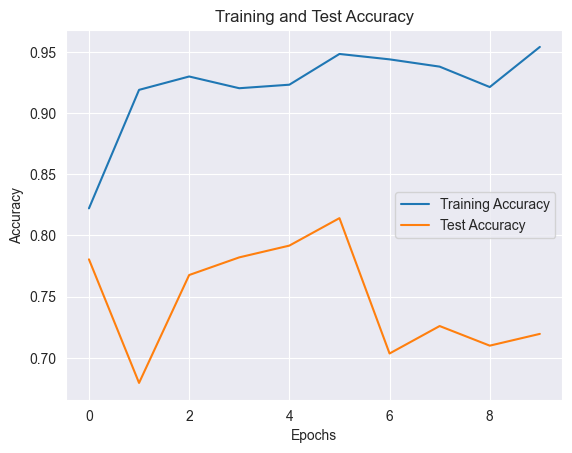

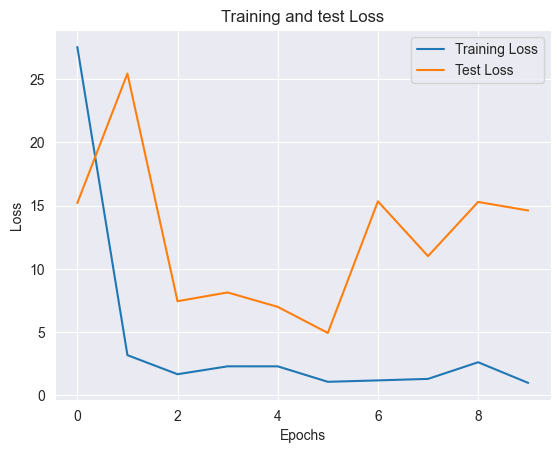

20/20 [==============================] - 1s 15ms/step


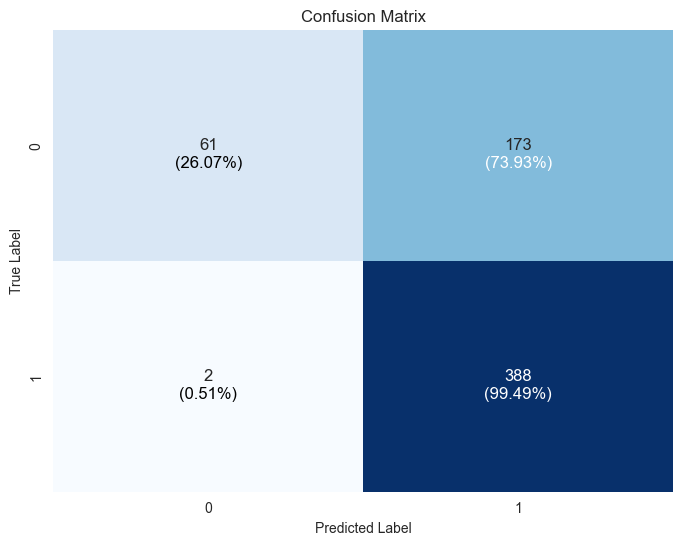

20/20 [==============================] - 0s 13ms/step - loss: 14.6162 - accuracy: 0.7196
Précision sur l'ensemble de test : 0.7195512652397156
IA model create


In [61]:
ai_cnn = get_ai("cnn")

Test VGG AI model

In [ ]:
ai_vgg = get_ai("vgg")

Test MLP AI model

In [ ]:
ai_mlp = get_ai("mlp")